# General setting

In [ ]:
!apt install swig
!pip install stable-baselines3[extra]

import torch
if torch.__version__ !='1.11.0+cu102':
  print('change version')
  !pip uninstall torch
  !pip install torch==1.11.0
elif torch.__version__ == '1.11.0+cu102':
  print('correct version')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,212 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 155673 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpa

change version
Found existing installation: torch 1.12.0+cu113
Uninstalling torch-1.12.0+cu113:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.12.0+cu113.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
    /usr/local/lib/python3.7/dist-packages/torchgen/*
Proceed (y/n)? y
y
y
  Successfully uninstalled torch-1.12.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 750.6 MB 10 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0+cu113 requires torch==1.12.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.13.0 requires torch==1.12.0, but you

In [ ]:
import gym
gym.__version__


'0.21.0'

In [ ]:
from google.colab import drive
import os
import sys
import pandas as pd
import numpy as np
import gym
drive.mount('/content/drive/',force_remount=True)
#helper directory
sys.path.insert(0,'/content/drive/MyDrive/BackUp_RL_CodeBase/helpers')
#file directory
os.chdir('/content/drive/MyDrive/BackUp_RL_CodeBase/')
#saving directory
path = os.getcwd()
save_dir = path + '/log_RL/20152020/'
model_dir = path+ '/trained_models/20152020/'
result_dir = path+ '/resultsRL/20152020/'
print(f'save_dir: {save_dir}')
print(f'model_dir: {model_dir}')
print(f'result_dir: {result_dir}')
print(f'result_dir: {result_dir}')

Mounted at /content/drive/
save_dir: /content/drive/MyDrive/BackUp_RL_CodeBase/log_RL/20152020/
model_dir: /content/drive/MyDrive/BackUp_RL_CodeBase/trained_models/20152020/
result_dir: /content/drive/MyDrive/BackUp_RL_CodeBase/resultsRL/20152020/
result_dir: /content/drive/MyDrive/BackUp_RL_CodeBase/resultsRL/20152020/


In [ ]:
#small helpers
import config
from helperFunction import data_split,splitByRatio  
from helperFunction import get_attributes,get_method

#standard lib
from gym.utils import seeding
from gym import spaces

from stable_baselines3.common.vec_env import DummyVecEnv,VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import A2C, DDPG, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure
import torch as th

import matplotlib.pyplot as plt
%matplotlib inline


# User Inputs

In [ ]:
schedule=pd.read_excel("trainingSchedule.xlsx",sheet_name = 'Value',index_col='Id')

In [ ]:
# specify model name and logfile name
train_id = 0 # input 1
nTimes = 1000 # input 2
note = 'AS_D252' # input 3 
agent = 'PPO' # input 4 

# training date
train_s = schedule.trainStart[train_id]
train_e = schedule.trainEnd[train_id]
# testing date
test_s = schedule.testStart[train_id]
test_e = schedule.testEnd[train_id]
# reload model
if train_id == 0:
  reload = False
else:
  reload =True
  reloadModel = schedule.ModelName[train_id-1]
trainY = train_s[2:4]+train_e[2:4]
trainM = train_s[5:7]+train_e[5:7]
testY = test_s[2:4] + test_e[2:4]

# log folder and model name
log_folder = f'{agent}_{train_id}_{nTimes}_{trainY}_{trainM}_{note}/'
print(f'log to diretory: {save_dir}{log_folder}')
# make log directory if not exist:
if not os.path.exists(f'{save_dir}{log_folder}'):
    os.makedirs(f'{save_dir}{log_folder}')
    print(f'logging directory made')


# model name and dir
model_name = f'{agent}_{train_id}_{nTimes}_{trainY}_{trainM}_{note}'
print(f'model saving to: {model_dir} as {model_name}')



log to diretory: /content/drive/MyDrive/BackUp_RL_CodeBase/log_RL/20152020/PPO_0_1000_1415_1212_AS_D252/
model saving to: /content/drive/MyDrive/BackUp_RL_CodeBase/trained_models/20152020/ as PPO_0_1000_1415_1212_AS_D252


# Data Prep

## Read input and split data

In [ ]:
# read data for environment¨ E_cleanInput k days relative ranks
# subset train and add date progress into state rep

df=pd.read_pickle("Input/E_cleanInput.pkl")
df=df.sort_values(['tic','date'],ignore_index=True) 
train = data_split(df, train_s,train_e) # subset
test = data_split(df, test_s,test_e)
print( f'training: {len(train.date.unique())} days, Period:{train_s}:{train_e}')
print( f'testing: {len(test.date.unique())} days, Period:{test_s}:{test_e}')
def dateProg(df):
  '''Prep adding progress indicator to the state space'''
  adding = df
  adding['day'] = df.index /df.index[-1] +0
  for q in range(df.shape[0]):
    adding.ar.iloc[q]['day'] = df.day.iloc[q]
  return adding
train = dateProg(train)
test = dateProg(test)

training: 258 days, Period:2014-12-31:2015-12-31
testing: 257 days, Period:2015-12-31:2016-12-30


# Make Environment

In [ ]:
class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame, input data
        stock_dim : int, number of unique stocks
        initial_amount : int, start capital
        state_space: int, the dimension of input features
        action_space: int, equals stock dimension
        day: int, an increment number to control date
        tech_indicator_list: list, a list of technical indicator names in the dataframe
        transaction_cost_pct: float, transaction cost percentage per trade
        reward_scaling: float, scaling factor for reward, good for training

    Methods
    -------
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                initial_amount,
                transaction_cost_pct,
                state_space,
                action_space,
                lookback=252,
                day = 0):
        super(gym.Env, self).__init__() 
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim  
        self.initial_amount = initial_amount
        self.state_space = state_space
        self.action_space = action_space
        self.terminal = False  
        
        # action space is the number of stock
        self.action_space = spaces.Box(low = 0, high = 10,shape = (self.action_space,)) 
        # observation space is the daily return matrix with one year lookback period
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space,self.stock_dim+1))

        # select remaining data for a given date, and select the return matrix for that day. that will be the state, if we don't add more
        self.data = self.df.loc[self.day,:]
        self.ret = self.data.iloc[0]['ar']
        self.state = self.ret
   
        # book keeper
        # date memory
        self.date_memory=[self.data.date.unique()[0]]
        self.portfolio_value = self.initial_amount
        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [1]
        # self.portfolio_return_memory = [0]
        # eq initialization, could be random if needed.
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe Ratio: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            print("Model actions: ",actions)
            weights = self.softmax_normalization(actions) 
            print("Weights: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.ret = self.data.iloc[0]['ar']
            self.state = self.ret
            
            # debug print
            print(self.day)
            print(self.state)
            # print(f"last day memory: {last_day_memory}")
            # print(f"counter: {self.day}")
            # print(f"current day info: {self.data}")

            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            print(f'portfolio return:{portfolio_return}')
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            print(f'portfolio value:{self.portfolio_value}')
            self.portfolio_value = new_portfolio_value
            print(f"new portfolio value: {new_portfolio_value}")

            #debug print
            # print(f"close value t= {self.day} : {self.data.close.values}")
            # print(f"close value t= {self.day-1} : {last_day_memory.close.values}")
            # print(f" .......")
            # print(f"actions: {actions}")
            # print(f"weights: {weights}")
            # print(f" .......")
            # print(f"portfolio return Type: {type(portfolio_return)}")
            # print(f"portfolio return: {portfolio_return}")
            # print(f"new portfolio value Type: {type(new_portfolio_value)}")
            # print(f"new portfolio value: {new_portfolio_value}")

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # reward function
            # A) indexed portfolio value 
            self.reward = new_portfolio_value 
            # B) Portfolio return
            # self.reward = np.round(np.log(1+portfolio_return-0),4)



        return self.state, self.reward, self.terminal, {'weights':weights}

    def reset(self):
        # date and state
        self.terminal = False 
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.ret = self.data.iloc[0]['ar']
        self.state =self.ret
        print(f'Environment reset. Day: {self.day}, State: {self.state}')

        # bookkeeping
        self.date_memory=[self.data.date.unique()[0]] 
        self.portfolio_value = self.initial_amount
        # self.portfolio_return_memory = [0]
        self.portfolio_return_memory = [1] # using port return
        self.asset_memory = [self.initial_amount]

        #initialize action equally
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        # self.actions_memory=[[1/(self.stock_dim-1)]*(self.stock_dim-1)] # substract 1 as we have day progress bar along the way
        #random initialization at rest
        # ls= np.random.default_rng(seed=0).random((42))
        # self.actions_memory = [(ls/ls.sum()).tolist()]
        # Another test
        # self.actions_memory = initWeight
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=0):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs
    
    def close(self):
      pass

# create environment, # get_attributes(e_train_gym)
print(f'number of tickers : {len(train.tic.unique())}')
print(f'training period : {len(train.date.unique())}')

# environment setting
stock_dimension = len(train.tic.unique())
state_space =1 # single input for state representation
env_kwargs = {
    "initial_amount": 1, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    "action_space":stock_dimension,}
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

# define environment
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
print( f'action space: {e_train_gym.action_space}, observation_space: {e_train_gym.observation_space}')
# get_attributes(e_train_gym)

#normalize the environment
mon_env = Monitor(e_train_gym,filename = f'{save_dir}{log_folder}',allow_early_resets=False)
env = DummyVecEnv([lambda:mon_env])
e_train_gym = VecNormalize(env)


number of tickers : 42
training period : 258
Stock Dimension: 42, State Space: 1
action space: Box([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10.], (42,), float32), observation_space: Box([[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]], [[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
  inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
  inf inf inf inf inf inf inf]], (1, 43), float32)


# Define/Reload the agent


In [ ]:
if reload == True:
  model = PPO.load(f"{model_dir}{reloadModel}", env=e_train_gym)
  print(f'{reloadModel} reloaded model from {model_dir}')
  # eval_return, eval_std = evaluate_policy(model = model, env = e_train_gym, \
  #                 n_eval_episodes=2, deterministic=True, \
  #                 render=False, callback=None, \
  #                 reward_threshold=None, return_episode_rewards=True, warn=True)
  # print(f'average reward :{np.round(eval_return,2)} std reward : {np.round(eval_std,2)}')
  # set logger directory and outputfiles
  reward_logger = configure(f'{save_dir}{log_folder}',["csv","tensorboard"])
  model.set_logger(reward_logger)
  print(f'logging to diretory: {save_dir}{log_folder}')

else:
  print(f'agent defined: {agent}')
  policy_kwargs = dict(activation_fn=th.nn.ReLU,
                    net_arch=[dict(pi=[400,300], vf=[400,300])])
  model = PPO("MlpPolicy", env = e_train_gym , verbose=1,learning_rate = 0.0001, \
              n_steps = 5, batch_size = 5, n_epochs = 10, seed= 123,\
              gamma = 0.99, gae_lambda=0.95, clip_range = 0.05,\
              policy_kwargs = policy_kwargs,tensorboard_log = f'{save_dir}{log_folder}')
  # set logger directory and outputfiles
  reward_logger = configure(f'{save_dir}{log_folder}',["csv","tensorboard"])
  model.set_logger(reward_logger)
  print(f'logging to diretory: {save_dir}{log_folder}')


PPO_0_1000_1415_1212_AS_D252 reloaded model from /content/drive/MyDrive/BackUp_RL_CodeBase/trained_models/20152020/
logging to diretory: /content/drive/MyDrive/BackUp_RL_CodeBase/log_RL/20152020/PPO_0_1000_1415_1212_AS_D252/


In [ ]:
# # continou train, rename existing model and change logfile to folder, and result file if needed
# model = PPO.load(f"{model_dir}{model_name}", env=e_train_gym)
# print(f'{model_name} reloaded model from {model_dir}')
# reward_logger = configure(f'{save_dir}{log_folder}',["csv","tensorboard"])
# model.set_logger(reward_logger)
# print(f'logging to diretory: {save_dir}{log_folder}')

## Train the agent

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True

# trainingsteps
epsLen = int(train.shape[0] / len(train.tic.unique()))
TIMESTEPS = epsLen* nTimes
print(f'episodic length: {epsLen},training times: {nTimes}, total steps: {TIMESTEPS}')
trainedmodel = model.learn(total_timesteps=TIMESTEPS,log_interval=epsLen,\
                           reset_num_timesteps=True,\
                         callback=TensorboardCallback(),tb_log_name=f'{save_dir}{log_folder}')

In [ ]:
#  save model
# get_attributes(trainedmodel)
print(f'model saved to: {model_dir} as {model_name}')
trainedmodel.save(f'{model_dir}{model_name}')

In [ ]:
# read log
result = pd.read_csv(f'{save_dir}{log_folder}progress.csv')
result

# In sample Test

In [ ]:
def DRL_prediction(model, environment, deterministic=True):
    test_env, test_obs = environment.get_sb_env()
    """make a prediction"""
    account_memory = []
    actions_memory = []
    list_raw_acitons = []
#         state_memory=[] #add memory pool to store states
    test_env.reset()
    for i in range(len(environment.df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        list_raw_acitons.append(action)
        if i == (len(environment.df.index.unique()) - 2):
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
#                 state_memory=test_env.env_method(method_name="save_state_memory") # add current state to state memory
        if dones[0]:
            print("hit end!")
            break
    return account_memory[0], actions_memory[0], list_raw_acitons

In [ ]:
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)    
dfIn_daily_return, dfIn_actions, dfIn_actionsRaw = DRL_prediction(model=trainedmodel,
                        environment = e_train_gym)

Streaming output truncated to the last 5000 lines.
            ABI.BR  ADS.DE  AI.PA  ALV.DE  ASML.AS  BAS.DE  BAYN.DE  BBVA.MC  \
2015-04-22    12.0     6.0   21.0    13.0     42.0     7.0     10.0     31.0   

            BMW.DE  BN.PA  ...  SAF.PA  SAN.MC  SAN.PA  SAP.DE  SIE.DE  \
2015-04-22     5.0   37.0  ...    39.0    24.0    35.0    29.0    11.0   

            STLA.MI  SU.PA  TTE.PA  VOW.DE       day  
2015-04-22     27.0   30.0    16.0    26.0  0.299611  

[1 rows x 43 columns]
portfolio return:0.00016391986312576774
portfolio value:1.198399123455321
new portfolio value: 1.198595564875608
Model actions:  [10.        10.        10.         0.        10.         0.
  0.         0.         0.         0.         0.        10.
  0.         0.         0.        10.         0.         0.
 10.        10.         0.        10.         0.         0.
  0.         1.8188426 10.        10.         0.        10.
  0.        10.        10.        10.        10.        10.
  0.         0.  

## In sample performance

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


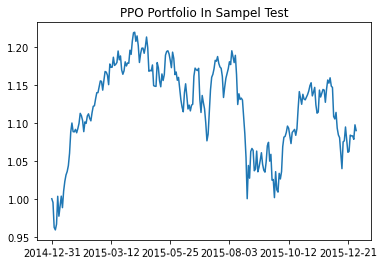

In [ ]:
dfIn_daily_return.daily_return.iloc[0] = 0
dfIn_daily_return['Indexed'] = (dfIn_daily_return.daily_return+1).cumprod()
dfIn_daily_return.Indexed.plot(title =f'{agent} Portfolio In Sampel Test')
list_date = dfIn_actions.index.tolist()
if len(list_date) >50:
  xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
  plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
else:
  pass
plt.show()

In [ ]:
resISFile = f'PPO_{train_id}_InSample{trainY}.csv'
dfIn_daily_return.to_csv(f'{result_dir}{resISFile}',index=False)
print(f'file saved to {result_dir}{resISFile}')

file saved to /content/drive/MyDrive/BackUp_RL_CodeBase/resultsRL/20152020/PPO_0_InSample1415.csv


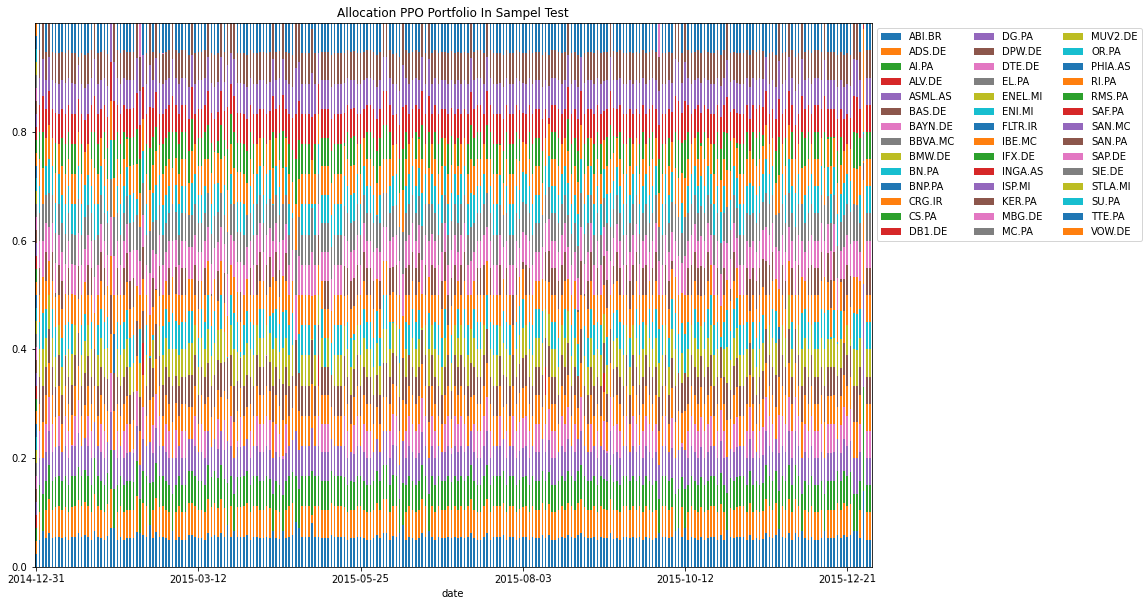

In [ ]:
list_date = dfIn_actions.index.tolist()
xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
dfIn_actions.plot.bar(title =f'Allocation {agent} Portfolio In Sampel Test',figsize=(15,10),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=3)
if len(list_date) >50:
  xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
  plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
else:
  pass
plt.show()

In [ ]:
actISFile = f'PPO_{train_id}_InSample{trainY}A.csv'
dfIn_actions.to_csv(f'{result_dir}{actISFile}')
print(f'file saved to {result_dir}{actISFile}')

file saved to /content/drive/MyDrive/BackUp_RL_CodeBase/resultsRL/20152020/PPO_0_InSample1415A.csv


## Other Portfolio's

In [ ]:
# def optimalPort(df):
#   #optimal portfolio more assets, takes train as input
#   from scipy.special import softmax
#   pct = df.pivot(columns='tic',values='close',index='date').pct_change()
#   ranks = pct.rank(axis=1,method='min') # rank of the return
#   weights = softmax(ranks,axis=1) # softmaxed rank
#   # store in df
#   maxPort = pd.DataFrame()
#   maxPort_R = pd.DataFrame()
#   maxPort_W = pd.DataFrame()
#   maxPort_R[[tick +'_returns' for tick in listSelection]] =pct
#   maxPort_W[[tick +'_weights' for tick in listSelection]] = weights
#   maxPort_RW = pd.DataFrame(maxPort_R.values * maxPort_W.values, columns=maxPort_R.columns, index=maxPort_R.index)
#   maxPort['PortRet'] = maxPort_RW.sum(axis=1)
#   maxPort['Indexed'] = (maxPort['PortRet']+1).cumprod()

#   # # Inverted
#   ranksInv = pct.rank(axis=1,method='min',ascending=False) # rank of the return
#   weightsInv = softmax(ranksInv,axis=1) # softmaxed rank
#   maxPortInverted_R = pd.DataFrame()
#   maxPortInverted_W = pd.DataFrame()
#   maxPortInverted_R = pct
#   maxPortInverted_W = weightsInv
#   maxPortInverted_RW = pd.DataFrame(maxPortInverted_R.values * maxPortInverted_W.values, columns=maxPortInverted_R.columns, index=maxPortInverted_R.index)
#   #store value
#   maxPort['PortRetInv'] = maxPortInverted_RW.sum(axis=1)
#   maxPort['IndexedInv'] = (maxPort['PortRetInv']+1).cumprod()
#   maxPort.Indexed.iloc[0] = 1
#   maxPort.IndexedInv.iloc[0] = 1
#   return maxPort
# maxPort = optimalPort(train)  

In [ ]:
# def equalPort(df):
#   #equally weighted
#   pct = train.pivot(columns='tic',values='close',index='date').pct_change()
#   eqPort = pct
#   eqPort = pd.DataFrame()
#   eqPort_R = pd.DataFrame()
#   eqPort_W = pd.DataFrame()
#   eqPort_R[[tick +'_returns' for tick in listSelection]] =pct
#   eqPort_W[[tick +'_weightsEQ' for tick in listSelection]] = np.ones(shape=pct.shape)*(1/len(listSelection))
#   eqPort_RW = pd.DataFrame(eqPort_R.values * eqPort_W.values, columns=eqPort_R.columns, index=eqPort_R.index)
#   eqPort['PortRetEQ'] = eqPort_RW.sum(axis=1)
#   eqPort['IndexedEQ'] = (eqPort['PortRetEQ']+1).cumprod()
#   eqPort.IndexedEQ.iloc[0] =1
#   return eqPort
# eqPort = equalPort(train)


In [ ]:
# # Min Max of the Random Agent
# rndAgent = rndAgent.set_index(keys='date', drop=True) # reset index
# rndMax = rndAgent.idxmax(axis=1)[-1] # return sim with max end return
# rndMin = rndAgent.idxmin(axis=1)[-1] # return sim with max end return

In [ ]:
# # expert model
# def stateInput(df):
#   stateInput = pd.DataFrame()
#   for q in range(0,len(df.date),(len(df.tic.unique()))):
#     temp = df.ar.iloc[q]
#     if q != 0:
#       stateInput = stateInput.append(temp)
#     else:
#       stateInput = temp
#   stateInput = stateInput.drop(columns ='day') 
#   return stateInput

# train_state = stateInput(train)
# pct = train.pivot(columns='tic',values='close',index='date').pct_change()
# weights = softmax(train_state,axis=1) # softmaxed rank

# expertPort = pd.DataFrame()
# expertPort_R = pd.DataFrame()
# expertPort_W = pd.DataFrame()
# expertPort_R[[tick +'_returns' for tick in listSelection]] =pct
# expertPort_W[[tick +'_weightsEQ' for tick in listSelection]] = weights
# expertPort_RW = pd.DataFrame(expertPort_R.values * expertPort_W.values, columns=expertPort_R.columns, index=expertPort_R.index)
# expertPort['PortRetEXP'] = expertPort_RW.sum(axis=1)
# expertPort['IndexedEXP'] = (expertPort['PortRetEXP']+1).cumprod()
# expertPort.IndexedEXP.iloc[0] =1


In [ ]:
# ticStep=50 # tic step time
# #drl agent
# ax2=model_cumpod.plot(title='In Sample Test',label =f'{agent} Portfolio In Sampel Test',legend=True,color='blue')
# # optimals
# maxPort.Indexed.plot(label ='Optimal Portfolio',ax=ax2,legend=True,color='green')
# maxPort.IndexedInv.plot(label='Inverted Optimal Portfolio', ax=ax2,legend=True,color='red')
# #random agent
# rndAgent[rndMax].plot(label='Simulation Random Agent Maximum',legend=True,ax=ax2,color ='pink')
# rndAgent[rndMin].plot(label='Simulation Random Agent Minimum',legend=True,ax=ax2,color='pink')
# # another 
# expertPort.IndexedEXP.plot(label='Expert model',legend=True,ax=ax2)
# #eq wgted
# eqPort.IndexedEQ.plot(label='Equally weighted Portfolio',ax=ax2,legend=True,color='orange').legend(bbox_to_anchor=(1.0, 1.0),ncol=1)
# list_date = dfIn_actions.index.tolist()
# xtic = [list_date[i] for i in range(0,len(list_date),ticStep)]#tic
# if len(list_date) >50:
#   plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=45) 
# else:
#   pass
# plt.show()

# Out of sample Test

In [ ]:
# environment
e_test_gym = StockPortfolioEnv(df = test, **env_kwargs)

# test model
dfOut_daily_return, dfOut_actions, dfOut_actionsRaw = DRL_prediction(model=trainedmodel,environment = e_test_gym)

Streaming output truncated to the last 5000 lines.
            ABI.BR  ADS.DE  AI.PA  ALV.DE  ASML.AS  BAS.DE  BAYN.DE  BBVA.MC  \
2016-04-22    15.0    32.0   13.0    25.0     31.0    21.0     24.0     39.0   

            BMW.DE  BN.PA  ...  SAF.PA  SAN.MC  SAN.PA  SAP.DE  SIE.DE  \
2016-04-22     8.0   12.0  ...     4.0    37.0    23.0    28.0    20.0   

            STLA.MI  SU.PA  TTE.PA  VOW.DE       day  
2016-04-22      5.0   35.0    33.0     7.0  0.304688  

[1 rows x 43 columns]
portfolio return:-0.009094798224925467
portfolio value:1.0110911481235436
new portfolio value: 1.0018954781443519
Model actions:  [10. 10. 10.  0. 10.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0. 10.  0.  0.
 10. 10.  0. 10.  0.  0.  0.  0. 10. 10.  0. 10.  0. 10. 10. 10. 10. 10.
  0.  0.  0.  0. 10.  0.]
Weights:  [5.5552192e-02 5.5552192e-02 5.5552192e-02 2.5220654e-06 5.5552192e-02
 2.5220654e-06 2.5220654e-06 2.5220654e-06 2.5220654e-06 2.5220654e-06
 2.5220654e-06 5.5552192e-02 2.5220654e-06 2.5220654

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


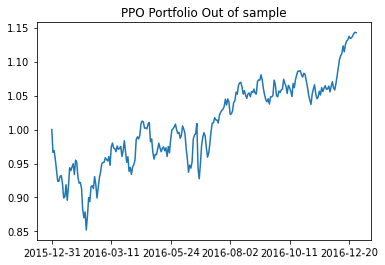

In [ ]:
dfOut_daily_return.daily_return.iloc[0] =0
dfOut_daily_return['Indexed'] = (dfOut_daily_return.daily_return+1).cumprod()
dfOut_daily_return.Indexed.plot(title =f'{agent} Portfolio Out of sample')
list_date = dfOut_actions.index.tolist()
if len(list_date) >50:
  xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
  plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
else:
  pass
plt.show()

In [ ]:
resOUTFile = f'PPO_{train_id}_OutofSample{testY}.csv'
dfOut_daily_return.to_csv(f'{result_dir}{resOUTFile}',index=False)
print(f'file saved to {result_dir}{resOUTFile}')

file saved to /content/drive/MyDrive/BackUp_RL_CodeBase/resultsRL/20152020/PPO_0_OutofSample1516.csv


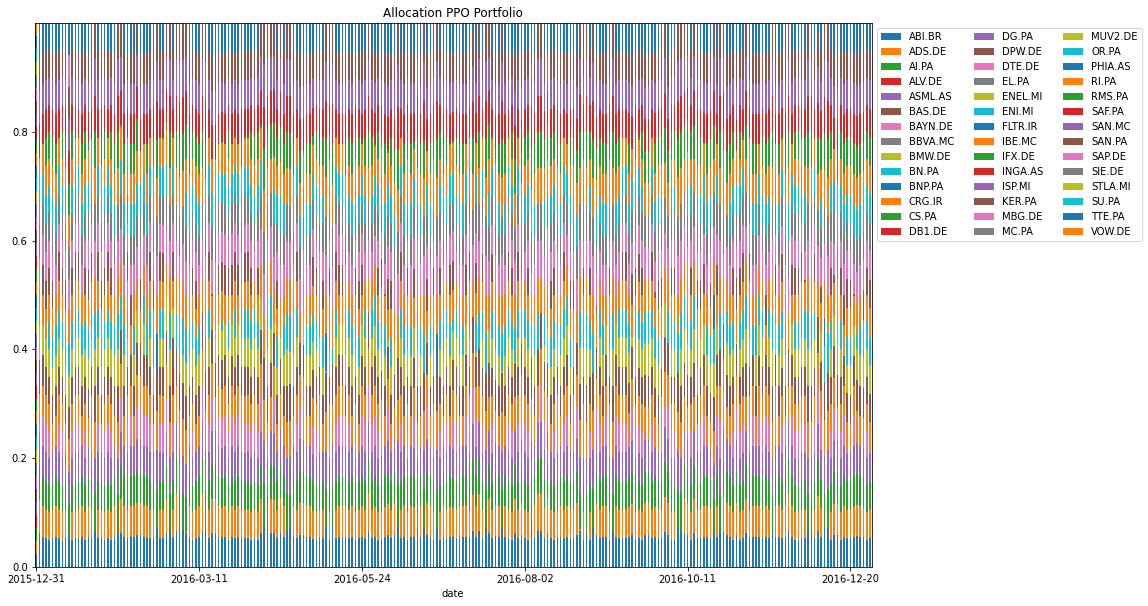

In [ ]:
list_date = dfOut_actions.index.tolist()
xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
dfOut_actions.plot.bar(title =f'Allocation {agent} Portfolio',figsize=(15,10),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=3)
if len(list_date) >50:
  xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
  plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
else:
  pass
plt.show()

In [ ]:
actOUTFile = f'PPO_{train_id}_OutofSample{testY}A.csv'
dfOut_actions.to_csv(f'{result_dir}{actOUTFile}')
print(f'file saved to {result_dir}{actOUTFile}')

file saved to /content/drive/MyDrive/BackUp_RL_CodeBase/resultsRL/20152020/PPO_0_OutofSample1516A.csv


# Log

In [ ]:
result.plot(subplots=True, layout=(5,5),figsize=(22,20))

from doc the https://stable-baselines3.readthedocs.io/en/master/common/logger.html#rollout:

ep_rew_mean: Mean episodic training reward (averaged over 100 episodes), a Monitor wrapper is required to compute that value (automatically added by make_vec_env).`

https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html#how-to-evaluate-an-rl-algorithm

As some policy are stochastic by default (e.g. A2C or PPO), you should also try to set deterministic=True when calling the .predict() method, this frequently leads to better performance. Looking at the training curve (episode reward function of the timesteps) is a good proxy but underestimates the agent true performance.

In [ ]:
(result['rollout/ep_rew_mean']/len(train.date.unique())).plot(title = 'Mean Episodic Reward')

In [ ]:
# another log file, monitor file
# # read monitor file and plot return from moniotr file
# from stable_baselines3.common.monitor import load_results
# r1 = load_results(f'{save_dir}{log_folder}')

In [ ]:
result.iloc[147]

In [ ]:
result['rollout/ep_rew_mean'].idxmax()

In [ ]:
300.65/258

In [ ]:
10578/258